<a href="https://colab.research.google.com/github/lipecamara/portifolio/blob/main/Regressao_portifolio_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold
import statsmodels.api as sm
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import joblib

In [2]:
df = pd.read_csv('/content/insurance.csv')
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [3]:
df.duplicated().sum()

np.int64(1)

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

colunas = df.columns

one_hot = make_column_transformer((OneHotEncoder(drop = 'if_binary'),
                                   ['sex', 'children', 'smoker', 'region']),
                                  remainder='passthrough', sparse_threshold=0)

df = one_hot.fit_transform(df)

df = pd.DataFrame(df, columns = one_hot.get_feature_names_out(colunas))

In [6]:
df.columns = ['sexo', 'dependentes_0','dependentes_1', 'dependentes_2', 'dependentes_3', 'dependentes_4', 'dependentes_5',
              'fumante', 'nordeste', 'noroeste', 'sudeste', 'sudoeste', 'idade', 'imc', 'valor_cobrado']

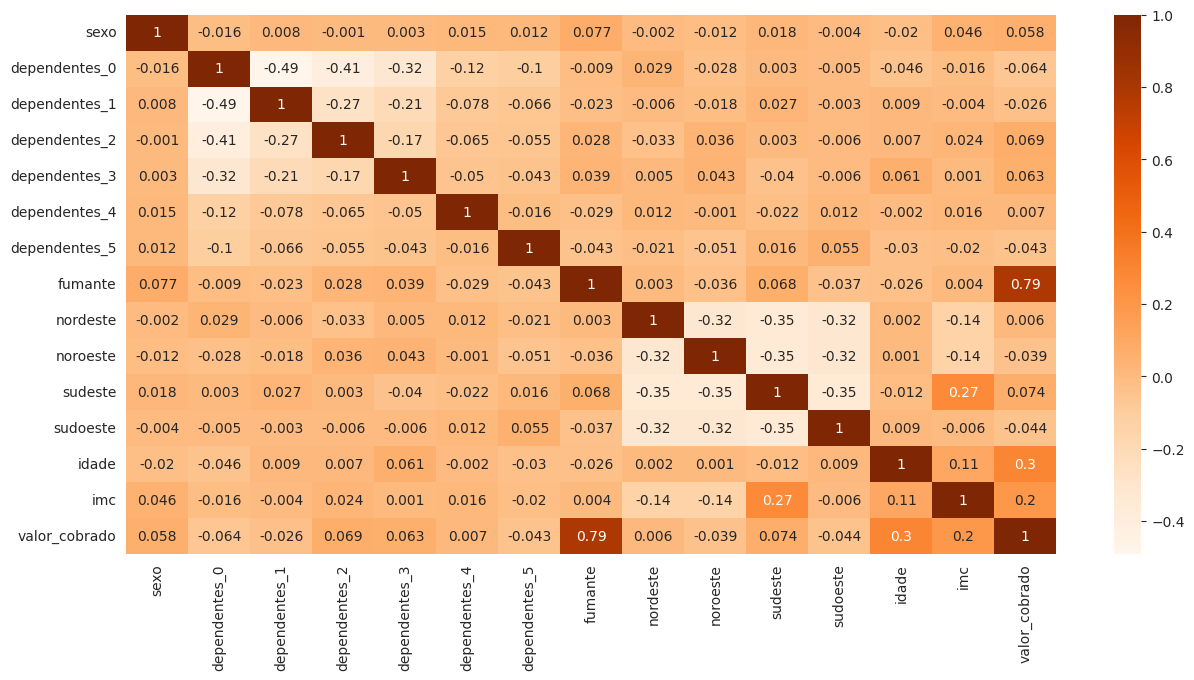

In [7]:
corr = df.corr().round(3)

sns.set_style('darkgrid')
ax = sns.heatmap(corr, cmap = 'Oranges', annot= True);
ax.figure.set_size_inches(15, 7)

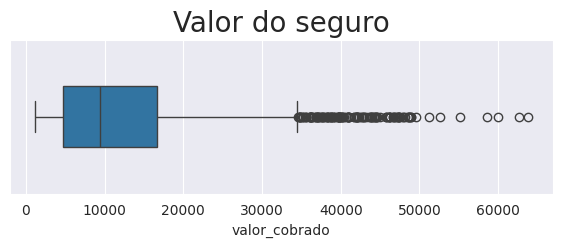

In [8]:
ax = sns.boxplot(df, x='valor_cobrado', width=0.4)
ax.figure.set_size_inches(7, 2)
ax.set_title('Valor do seguro', fontsize = 20)
plt.show()

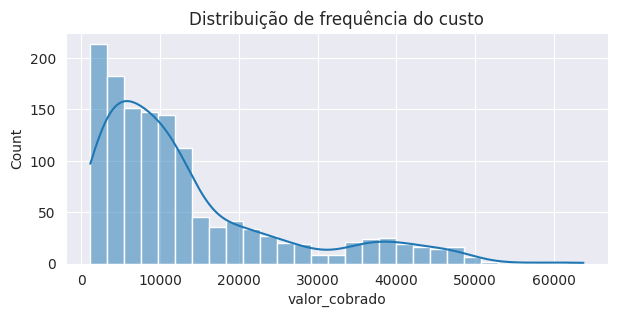

In [9]:
ax = sns.histplot(df['valor_cobrado'], kde = True)
ax.figure.set_size_inches(7, 3)
ax.set_title('Distribuição de frequência do custo')
plt.show()

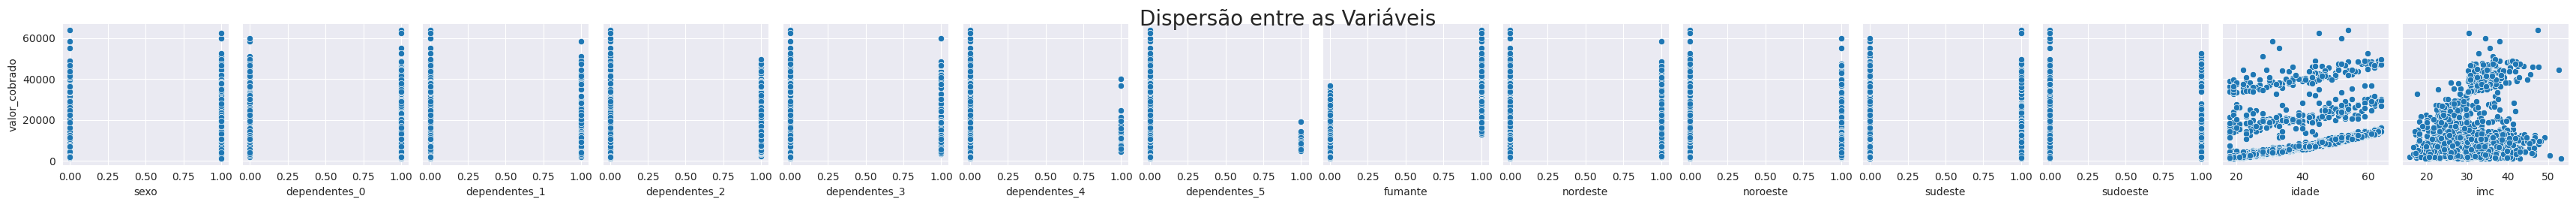

In [10]:
ax = sns.pairplot(df, y_vars="valor_cobrado", x_vars= ['sexo', 'dependentes_0', 'dependentes_1', 'dependentes_2',
       'dependentes_3', 'dependentes_4', 'dependentes_5', 'fumante',
       'nordeste', 'noroeste', 'sudeste', 'sudoeste', 'idade', 'imc'])
ax.figure.suptitle('Dispersão entre as Variáveis', fontsize=20, y=1.05)
plt.show()

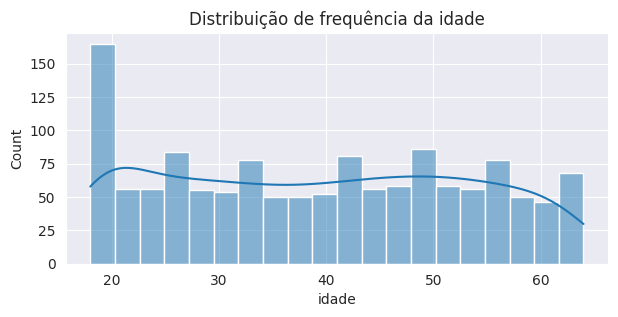

In [11]:
ax = sns.histplot(df['idade'], kde = True, bins = 20)
ax.figure.set_size_inches(7, 3)
ax.set_title('Distribuição de frequência da idade')
plt.show()

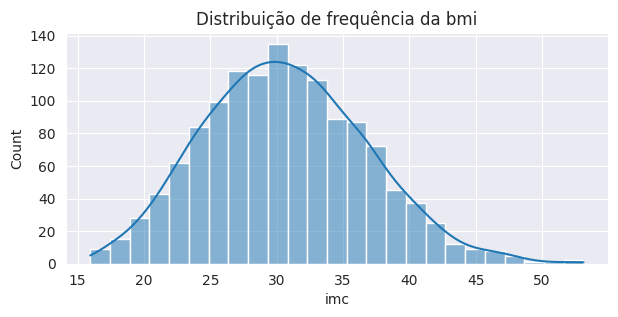

In [12]:
ax = sns.histplot(df['imc'], kde = True)
ax.figure.set_size_inches(7, 3)
ax.set_title('Distribuição de frequência da bmi')
plt.show()

In [13]:
df['log_valor_cobrado'] = np.log(df['valor_cobrado'])

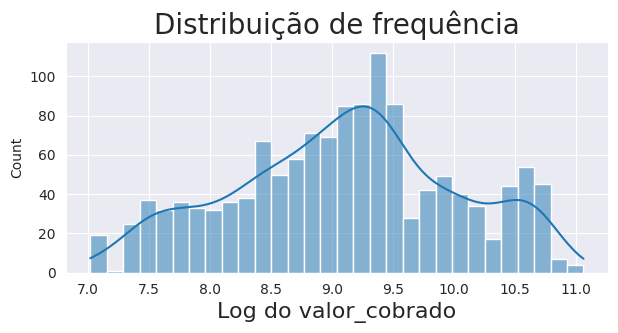

In [14]:
ax = sns.histplot(df['log_valor_cobrado'], kde=True, bins = 30)

ax.figure.set_size_inches(7, 3)
ax.set_title('Distribuição de frequência', fontsize=20)
ax.set_xlabel('Log do valor_cobrado', fontsize=16)
plt.show()

In [15]:
X = df[['sexo', 'dependentes_0', 'dependentes_1', 'dependentes_2',
       'dependentes_3', 'dependentes_4', 'dependentes_5', 'fumante',
       'nordeste', 'noroeste', 'sudeste', 'sudoeste', 'idade', 'imc']]
y = df['log_valor_cobrado']

In [16]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state=40)

In [17]:
X_treino_com_constante = sm.add_constant(X_treino)
X_treino_com_constante.head(3)

,const,sexo,dependentes_0,dependentes_1,dependentes_2,dependentes_3,dependentes_4,dependentes_5,fumante,nordeste,noroeste,sudeste,sudoeste,idade,imc
404,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,31.0,20.40
693,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,27.0,34.80
436,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,22.0,31.73


In [18]:
# modelo OLS

modelo_ols = sm.OLS(y_treino, X_treino_com_constante, hasconst=True).fit()
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:      log_valor_cobrado   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     267.4
Date:                Tue, 22 Apr 2025   Prob (F-statistic):          2.24e-300
Time:                        12:39:57   Log-Likelihood:                -607.51
No. Observations:                1002   AIC:                             1241.
Df Residuals:                     989   BIC:                             1305.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.0851      0.062     81.721

In [19]:
explicativas = X_treino_com_constante.columns

vif = pd.DataFrame()
vif['variavel'] = explicativas

vif["vif"] = [variance_inflation_factor(X_treino_com_constante, i ) for i in range(len(explicativas))]

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [20]:
vif

,variavel,vif
0,const,0.000000
1,sexo,1.010827
2,dependentes_0,inf
3,dependentes_1,inf
4,dependentes_2,inf
5,dependentes_3,inf
6,dependentes_4,inf
7,dependentes_5,inf
8,fumante,1.017456
9,nordeste,inf


In [21]:
modelo_ols = sm.OLS(y_treino, X_treino_com_constante[['const', 'sexo', 'fumante', 'idade', 'imc']], hasconst=True).fit()
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:      log_valor_cobrado   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     711.3
Date:                Tue, 22 Apr 2025   Prob (F-statistic):          3.21e-290
Time:                        12:39:57   Log-Likelihood:                -655.93
No. Observations:                1002   AIC:                             1322.
Df Residuals:                     997   BIC:                             1346.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0881      0.086     82.704      0.0

In [22]:
modelo_ols = sm.OLS(y_treino, X_treino_com_constante[['const', 'fumante', 'idade', 'imc']], hasconst=True).fit()
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:      log_valor_cobrado   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     944.9
Date:                Tue, 22 Apr 2025   Prob (F-statistic):          5.48e-291
Time:                        12:39:57   Log-Likelihood:                -657.68
No. Observations:                1002   AIC:                             1323.
Df Residuals:                     998   BIC:                             1343.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0684      0.085     83.000      0.0

In [23]:
X_teste_com_constante = sm.add_constant(X_teste[['fumante', 'idade', 'imc']])

In [24]:
print(f'R² de teste: {r2_score(y_teste, modelo_ols.predict(X_teste_com_constante))}')
print(f'MAE do teste: {mean_absolute_error(np.exp(y_teste), np.exp(modelo_ols.predict(X_teste_com_constante)))}')
print(f'RMSE do teste: {root_mean_squared_error(np.exp(y_teste), np.exp(modelo_ols.predict(X_teste_com_constante)))}')

R² de teste: 0.7564350907947267
MAE do teste: 4257.137747620172
RMSE do teste: 8313.652653548634


In [25]:
X = df.drop(['valor_cobrado', 'log_valor_cobrado'], axis = 1)
y = df['valor_cobrado']

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, random_state=40)

In [26]:
# modelo árvore de decisao

param_grid = {
    'max_depth': [2, 3, 4, 6, 8, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [5, 10, 15],
    'max_leaf_nodes': [None, 100, 500]
}

arvore = DecisionTreeRegressor(random_state=40)
gs_arvore = GridSearchCV(estimator=arvore, param_grid=param_grid, cv = 5, n_jobs=-1)
gs_arvore.fit(X_treino, y_treino)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=40), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 6, 8, 10, 15],
                         'max_leaf_nodes': [None, 100, 500],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [2, 5, 10]})

In [27]:
arvore_otimizada = gs_arvore.best_estimator_

In [28]:
print(gs_arvore.best_params_)

{'max_depth': 4, 'max_leaf_nodes': None, 'min_samples_leaf': 15, 'min_samples_split': 2}


In [29]:
y_pred_treino = arvore_otimizada.predict(X_treino)
y_pred = arvore_otimizada.predict(X_teste)

print('Métricas conjunto de treino:')
print('R²:', r2_score(y_treino, y_pred_treino))
print('MAE:', mean_absolute_error(y_treino, y_pred_treino))
print('RMSE:', root_mean_squared_error(y_treino, y_pred_treino))

print('\n\nMétricas conjunto de teste:')
print('R²:', r2_score(y_teste, y_pred))
print('MAE:', mean_absolute_error(y_teste, y_pred))
print('RMSE:', root_mean_squared_error(y_teste, y_pred))

Métricas conjunto de treino:
R²: 0.8630754066849753
MAE: 2628.226492155007
RMSE: 4440.25119680317


Métricas conjunto de teste:
R²: 0.8697102696328047
MAE: 2739.385286292848
RMSE: 4481.643163048549


In [30]:
cv = KFold(n_splits=5, shuffle=True, random_state=40)
resultados = cross_validate(arvore_otimizada, X, y, scoring='neg_mean_squared_error', cv = cv, return_train_score=True)

In [31]:
treino_rmse = np.sqrt(-resultados['train_score'])
teste_rmse = np.sqrt(-resultados['test_score'])

print("Treino RMSE em cada fold:", treino_rmse)
print("Teste RMSE em cada fold:", teste_rmse)
print("\nMédia do RMSE no treino:", treino_rmse.mean())
print("Média do RMSE no teste:", teste_rmse.mean())

Treino RMSE em cada fold: [4472.97103703 4486.09602397 4413.43480734 4366.9511614  4145.10391085]
Teste RMSE em cada fold: [4349.53710197 4171.57971554 4568.68352503 4778.69118152 5475.41319391]

Média do RMSE no treino: 4376.911388118874
Média do RMSE no teste: 4668.7809435937015


In [32]:
# modelo XGBoost

param_grid = {
    'learning_rate': [0.01, 1],
    'max_depth': [2, 3, 4, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.4, 0.8, 0.6],
    'gamma': [0, 0.1]
}

gbm = xgb.XGBRegressor(enable_categorical=True)

grid = GridSearchCV(
    estimator = gbm,
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    verbose = 1
)

grid.fit(X_treino, y_treino)

print('Melhores hiperparâmetros encontrados: ', grid.best_params_)
print('Menor RMSE encontrado: ', np.sqrt(np.abs(grid.best_score_)))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Melhores hiperparâmetros encontrados:  {'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 1, 'max_depth': 2, 'subsample': 1}
Menor RMSE encontrado:  5244.646521434658


In [33]:
dtreino = xgb.DMatrix(X_treino, y_treino, enable_categorical=True)

params = {'objective': 'reg:squarederror', 'colsample_bytree': 0.4, 'gamma': 0, 'learning_rate': 1, 'max_depth': 2, 'subsample': 1}

cv_resultados = xgb.cv(dtrain=dtreino, params=params, nfold=5, num_boost_round=1000,
                       early_stopping_rounds=20, metrics='rmse', as_pandas=True, seed=40)

cv_resultados

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,11305.073939,168.354717,11453.210123,661.617807
1,11200.116486,165.387916,11460.080599,651.249971
2,11121.025231,161.355864,11460.462860,662.823174
3,10923.327202,152.630807,11476.248522,670.685074
4,4922.717179,28.288371,5208.644863,225.910313
5,4864.835465,31.846833,5167.359824,247.027701
6,4785.771901,24.421628,5104.787458,263.729393
7,4747.998167,29.116108,5076.186248,253.643597
8,4649.862763,39.949104,5045.144819,285.452472
9,4629.429366,44.875855,5051.229402,274.954432


In [34]:
modelo_final = grid.best_estimator_

y_pred = modelo_final.predict(X_teste)
y_pred_treino = modelo_final.predict(X_treino)

print('Métricas conjunto de treino:')
print('R²:', r2_score(y_treino, y_pred_treino))
print('MAE:', mean_absolute_error(y_treino, y_pred_treino))
print('RMSE:', root_mean_squared_error(y_treino, y_pred_treino))

print('\n\nMétricas conjunto de teste:')
print('R²:', r2_score(y_teste, y_pred))
print('MAE:', mean_absolute_error(y_teste, y_pred))
print('RMSE:', root_mean_squared_error(y_teste, y_pred))

Métricas conjunto de treino:
R²: 0.8998043438215865
MAE: 2264.0327051407353
RMSE: 3798.3174354498888


Métricas conjunto de teste:
R²: 0.8485495341673016
MAE: 2838.4637914126633
RMSE: 4831.895000777014


In [35]:
# modelo escolhido: árvore de decisão

parametros = {'max_depth': 4, 'max_leaf_nodes': None, 'min_samples_leaf': 15, 'min_samples_split': 2}

modelo_final = DecisionTreeRegressor(**parametros)
modelo_final.fit(X, y)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=15)

In [36]:
joblib.dump(modelo_final, 'modelo_regressao.pkl')

['modelo_regressao.pkl']